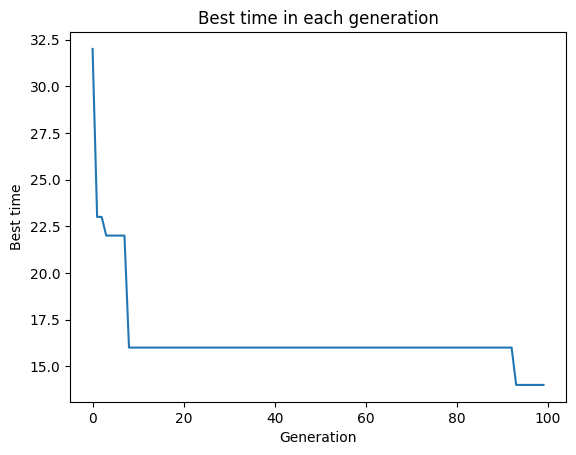

The total time was of: 14, 
from 'El Rosario' to 'Instituto del Petroleo' in ' linea 6', 
from 'Instituto del Petroleo' to 'La Raza' in ' linea 5', 
from 'La Raza' to 'Consulado' in ' linea 5', 
from 'Consulado' to 'Morelos' in ' linea 4', 
from 'Morelos' to 'San Lázaro' in ' linea B'


In [50]:
import random
from typing import List, Tuple
from rutas import *
from parameters import *
import matplotlib.pyplot as plt

Genome = Tuple[List[int], int, List[str], List[Tuple[str, str]]]

def generate_genome(rutas: List[Ruta], start_point: str, end_point: str) -> Genome:
    # Initialize the current_point with the start_point, and create empty lists for indexes and stages
    current_point, indexes, stages = start_point, [], []
    # Continue the loop until the current_point is not the end_point
    while current_point != end_point:
        # Choose a random route from the list of routes where the start of the route is the current_point
        i = random.choice([i for i, ruta in enumerate(rutas) if current_point == ruta.start])
        # Append the index of the chosen route to the indexes list
        indexes.append(i)
        # Append the current_point and the end of the chosen route to the stages list
        stages.append((current_point, rutas[i].end))
        # Update the current_point to the end of the chosen route
        current_point = rutas[i].end
    # Calculate the total time by summing up the time of each route in the indexes list
    time = sum(rutas[i].time for i in indexes)
    # Create a list of lines by getting the line of each route in the indexes list
    lineas = [rutas[i].linea for i in indexes]
    # Return the indexes, time, lines, and stages as a Genome
    return indexes, time, lineas, stages

# This function generates a population of genomes.
def generate_population(rutas: List[Ruta], size_pop) -> List[Genome]:
    # Each genome is a path from the start point to the end point.
    # The population size is determined by the size_pop parameter.
    return [generate_genome(rutas, start_point, end_point) for _ in range(size_pop)]

# This function calculates the fitness of a genome.
def fitness(genome: Genome, rutas: List[Ruta]) -> float:
    # The fitness is defined as the inverse of the total time of the path represented by the genome.
    # If the total time is 0, the fitness is also 0 to avoid division by zero.
    return 1/genome[1] if genome[1] != 0 else 0

# This function selects the top genomes from the population based on their fitness.
def elitism(population: List[Genome], rutas: List[Ruta], elite_size: int) -> List[Genome]:
    # The number of genomes to select is determined by the elite_size parameter.
    # If elite_size is less than 2, it is set to 2 to ensure that at least two genomes are selected.
    # The genomes are sorted in descending order of fitness, and the top genomes are returned.
    elite_size = max(2, elite_size)
    return sorted(population, key=lambda genome: fitness(genome, rutas), reverse=True)[:elite_size]

# This function mutates a genome by changing a part of its path.
def mutate_genome(genome: Genome, rutas: List[Ruta], start_point: str, end_point: str) -> Genome:    
    # Choose a random index in the genome to mutate
    index_to_mutate = random.randint(1, len(genome[0]) - 1)
    # Determine the new start point for the path to be generated
    new_start_point = rutas[genome[0][index_to_mutate - 1]].end
    # Generate a new path from the new start point to the end point
    new_route = generate_genome(rutas, new_start_point, end_point)
    # Create a new genome by replacing the part of the path after the mutation index with the new path
    new_genome = list(genome)
    new_genome[0] = new_genome[0][:index_to_mutate] + new_route[0]
    # Update the total time of the new genome
    new_genome[1] = sum(rutas[i].time for i in new_genome[0])
    # Update the lines of the new genome
    new_genome[2] = [rutas[i].linea for i in new_genome[0]]
    # Update the stages of the new genome
    new_genome[3] = [(rutas[i].start, rutas[i].end) for i in new_genome[0]]
    # Return the new genome
    return tuple(new_genome)

# This function performs a crossover operation between two parent genomes to produce a child genome.
def crossover(parent1: Genome, parent2: Genome, rutas: List[Ruta]) -> Genome:
    # Find the common stages between the two parents
    common_points = set(parent1[3]).intersection(set(parent2[3]))
    # If there are common stages, choose one at random to be the crossover point
    if common_points:
        crossover_point = random.choice(list(common_points))
        # Find the index of the crossover point in each parent
        crossover_index1 = parent1[3].index(crossover_point)
        crossover_index2 = parent2[3].index(crossover_point)
        # Create the child's route by taking the part of the first parent's route up to the crossover point
        # and the part of the second parent's route after the crossover point
        child_route = parent1[0][:crossover_index1+1] + parent2[0][crossover_index2+1:]
        # Do the same for the stages
        child_stages = parent1[3][:crossover_index1+1] + parent2[3][crossover_index2+1:]
    else:
        # If there are no common stages, the child is a copy of the first parent
        child_route = parent1[0]
        child_stages = parent1[3]
    # Calculate the total time of the child's route
    child_time = sum(rutas[i].time for i in child_route)
    # Get the lines of the child's route
    child_lineas = [rutas[i].linea for i in child_route]
    # Return the child genome
    return child_route, child_time, child_lineas, child_stages

# This function creates a new population of genomes for the next generation of the genetic algorithm.
def create_new_population(population: List[Genome], rutas: List[Ruta], elite_size: int, mutation_rate: float) -> List[Genome]:
    # Select the top genomes from the current population based on their fitness
    elite = elitism(population, rutas, elite_size)
    # Create a copy of the elite genomes
    elite_copy = [genome for genome in elite]
    # Initialize an empty list for the children genomes
    children = []
    # Generate the children genomes by performing crossover on pairs of elite genomes
    for _ in range(size_pop - len(elite)):
        # Select two parents for crossover from the elite genomes
        parent1, parent2 = random.sample(elite, 2)
        # Perform crossover on the parents to produce a child
        child = crossover(parent1, parent2, rutas)
        # Add the child to the children list
        children.append(child)
    # Perform mutation on the elite genomes with a certain probability
    for i in range(len(elite)):
        # If a random number is less than the mutation rate, perform mutation on the genome
        if random.random() < mutation_rate:
            # Perform mutation on the genome
            mutated = mutate_genome(elite[i], rutas, start_point, end_point)
            # If the fitness of the mutated genome is higher than the original genome, replace the original genome with the mutated one
            if fitness(mutated, rutas) > fitness(elite[i], rutas):
                elite[i] = mutated
    # Combine the elite genomes, their copies, and the children to form the new population
    return elite + elite_copy + children

# This function runs the genetic algorithm for a certain number of generations.
def genetic_algorithm(rutas: List[Ruta], num_generations: int, elite_size: int, mutation_rate: float) -> Tuple[Genome, List[int]]:
    # Initialize the population with randomly generated genomes
    population = generate_population(rutas, size_pop)
    # Initialize a list to keep track of the best time in each generation
    best_times = []
    # Run the genetic algorithm for the specified number of generations
    for _ in range(num_generations):
        # Create a new population for the next generation
        population = create_new_population(population, rutas, elite_size, mutation_rate)
        # Perform mutation on the genomes with a certain probability
        for i in range(len(population)):
            # If a random number is less than the mutation rate, perform mutation on the genome
            if random.random() < mutation_rate:
                mutated = mutate_genome(population[i], rutas, start_point, end_point)
                # If the fitness of the mutated genome is higher than the original genome, replace the original genome with the mutated one
                if fitness(mutated, rutas) > fitness(population[i], rutas):
                    population[i] = mutated
        # Find the best genome in the population and its time
        best_genome = max(population, key=lambda genome: fitness(genome, rutas))
        best_time = 1/best_genome[1] if best_genome[1] < 1 else best_genome[1]
        # Add the best time to the list of best times
        best_times.append(best_time)
        # Update elite_size based on the size of the elite from the last generation
        elite_size = len(elitism(population, rutas, elite_size))
    # Return the best genome and the list of best times
    return best_genome, best_times

best_genome, best_times = genetic_algorithm(rutas, num_generations, elite_size, mutation_rate)

plt.plot(best_times)
plt.title('Best time in each generation')
plt.xlabel('Generation')
plt.ylabel('Best time')
plt.show()

print(f"The total time was of: {best_genome[1]}, " + ", ".join(f"\nfrom '{a}' to '{b}' in ' linea {linea}'" for (a, b), linea in zip(best_genome[3], best_genome[2])))

In [64]:
genome_example = generate_genome(rutas, start_point, end_point)
print(genome_example)

([31, 81, 26, 81, 26, 32, 33, 88, 15, 82, 81, 26, 81, 26, 27, 16, 50, 38, 93, 105, 71, 70, 33, 22, 29, 54, 109, 108], 49, ['6', '5', '5', '5', '5', '6', '6', '6', '3', '5', '5', '5', '5', '5', '5', '3', 'B', '8', '8', 'B', '3', '3', '6', '4', '5', 'B', 'B', 'B'], [('El Rosario', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'Politécnico'), ('Politécnico', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'Politécnico'), ('Politécnico', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'Deportivo 18 de Marzo'), ('Deportivo 18 de Marzo', 'Martín Carrera'), ('Martín Carrera', 'Deportivo 18 de Marzo'), ('Deportivo 18 de Marzo', 'La Raza'), ('La Raza', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'Politécnico'), ('Politécnico', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'Politécnico'), ('Politécnico', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'La Raza'), ('La Raza', 'Guerrero'), ('Guerrero', 'Garibaldi'), ('Garibaldi', 'Bellas Artes'), ('Bella

In [57]:
population_example = generate_population(rutas, size_pop)
for genome in population_example:
    print(genome, "\n")

([31, 81, 26, 86, 34, 89, 31, 86, 34, 35, 90, 89, 31, 81, 26, 27, 28, 29, 108], 71, ['6', '5', '5', '6', '7', '7', '6', '6', '7', '7', '7', '7', '6', '5', '5', '5', '5', '5', 'B'], [('El Rosario', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'Politécnico'), ('Politécnico', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'El Rosario'), ('El Rosario', 'Tacuba'), ('Tacuba', 'El Rosario'), ('El Rosario', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'El Rosario'), ('El Rosario', 'Tacuba'), ('Tacuba', 'Tacubaya'), ('Tacubaya', 'Tacuba'), ('Tacuba', 'El Rosario'), ('El Rosario', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'Politécnico'), ('Politécnico', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'La Raza'), ('La Raza', 'Consulado'), ('Consulado', 'Oceanía'), ('Oceanía', 'San Lázaro')]) 

([34, 89, 34, 35, 42, 97, 36, 91, 8, 9, 93, 105, 71, 16, 17, 72, 17, 18, 73, 9, 93, 38, 39, 2, 11, 12, 13, 68, 102, 75, 43, 66, 11, 44, 80, 25, 99, 95, 2, 57, 56, 

In [58]:
for genome in population_example:
    print(fitness(genome, rutas))

0.014084507042253521
0.0035587188612099642
0.008695652173913044
0.003875968992248062
0.0036363636363636364
0.012195121951219513
0.01020408163265306
0.019230769230769232
0.005847953216374269
0.002976190476190476
0.012658227848101266
0.007462686567164179


In [59]:
elite_example = elitism(population_example, rutas, elite_size)
for genome in elite_example:
    print(genome, "\n")

([34, 35, 42, 20, 47, 102, 47, 67, 66, 57, 40, 44, 45, 100, 80, 4], 52, ['7', '7', '9', '3', '12', '12', '12', '2', '2', '1', '8', '9', '9', '9', '4', '1'], [('El Rosario', 'Tacuba'), ('Tacuba', 'Tacubaya'), ('Tacubaya', 'Centro Médico'), ('Centro Médico', 'Zapata'), ('Zapata', 'Ermita'), ('Ermita', 'Zapata'), ('Zapata', 'Ermita'), ('Ermita', 'Chabacano'), ('Chabacano', 'Pino Suárez'), ('Pino Suárez', 'Salto del Agua'), ('Salto del Agua', 'Chabacano'), ('Chabacano', 'Jamaica'), ('Jamaica', 'Pantitlán'), ('Pantitlán', 'Jamaica'), ('Jamaica', 'Candelaria'), ('Candelaria', 'San Lázaro')]) 

([31, 81, 26, 86, 34, 89, 31, 86, 34, 35, 90, 89, 31, 81, 26, 27, 28, 29, 108], 71, ['6', '5', '5', '6', '7', '7', '6', '6', '7', '7', '7', '7', '6', '5', '5', '5', '5', '5', 'B'], [('El Rosario', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'Politécnico'), ('Politécnico', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'El Rosario'), ('El Rosario', 'Tacuba'), ('Tacuba', 'El Rosario'), (

In [60]:
mutate_example = mutate_genome(genome_example, rutas, start_point, end_point)
print('original:', genome_example,
    '\nmutated :', mutate_example)

original: ([31, 32, 87, 27, 28, 83, 82, 27, 16, 71, 70, 87, 86, 34, 89, 34, 35, 62, 7, 36, 46, 101, 37, 92, 91, 8, 72, 17, 9, 39, 40, 41, 103, 67, 98, 43, 41, 96, 98, 43, 98, 20, 101, 37, 92, 91, 42, 97, 90, 35, 0, 55, 36, 46, 47, 102, 75, 97, 42, 74, 1, 40, 12, 102, 21, 76, 75, 74, 73, 72, 71, 16, 50, 105, 50, 105, 71, 16, 17, 72, 17, 9, 64, 63, 36, 46, 21, 76, 75, 43, 41, 103, 67, 95, 2, 3, 4], 282, ['6', '6', '6', '5', '5', '5', '5', '5', '3', '3', '3', '6', '6', '7', '7', '7', '7', '2', '2', '7', '12', '12', '7', '7', '7', '2', '3', '3', '2', '8', '8', '8', '12', '2', '9', '9', '8', '8', '9', '9', '9', '3', '12', '7', '7', '7', '9', '9', '7', '7', '1', '1', '7', '12', '12', '12', '3', '9', '9', '3', '1', '8', '2', '12', '3', '3', '3', '3', '3', '3', '3', '3', 'B', 'B', 'B', 'B', '3', '3', '3', '3', '3', '2', '2', '2', '7', '12', '3', '3', '3', '9', '8', '12', '2', '8', '1', '1', '1'], [('El Rosario', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'Deportivo 18 de Marzo'), ('

In [61]:
crossover_example = crossover(elite_example[0], elite_example[1], rutas)
print(crossover_example)

([34, 89, 31, 86, 34, 35, 90, 89, 31, 81, 26, 27, 28, 29, 108], 57, ['7', '7', '6', '6', '7', '7', '7', '7', '6', '5', '5', '5', '5', '5', 'B'], [('El Rosario', 'Tacuba'), ('Tacuba', 'El Rosario'), ('El Rosario', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'El Rosario'), ('El Rosario', 'Tacuba'), ('Tacuba', 'Tacubaya'), ('Tacubaya', 'Tacuba'), ('Tacuba', 'El Rosario'), ('El Rosario', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'Politécnico'), ('Politécnico', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'La Raza'), ('La Raza', 'Consulado'), ('Consulado', 'Oceanía'), ('Oceanía', 'San Lázaro')])


In [62]:
new_population_example = create_new_population(population_example, rutas, elite_size, mutation_rate)
for genome in new_population_example:
    print(genome, "\n")

([34, 35, 42, 20, 47, 102, 47, 67, 66, 57, 40, 44, 45, 100, 80, 4], 52, ['7', '7', '9', '3', '12', '12', '12', '2', '2', '1', '8', '9', '9', '9', '4', '1'], [('El Rosario', 'Tacuba'), ('Tacuba', 'Tacubaya'), ('Tacubaya', 'Centro Médico'), ('Centro Médico', 'Zapata'), ('Zapata', 'Ermita'), ('Ermita', 'Zapata'), ('Zapata', 'Ermita'), ('Ermita', 'Chabacano'), ('Chabacano', 'Pino Suárez'), ('Pino Suárez', 'Salto del Agua'), ('Salto del Agua', 'Chabacano'), ('Chabacano', 'Jamaica'), ('Jamaica', 'Pantitlán'), ('Pantitlán', 'Jamaica'), ('Jamaica', 'Candelaria'), ('Candelaria', 'San Lázaro')]) 

([31, 81, 26, 86, 34, 89, 31, 86, 34, 35, 90, 89, 31, 81, 26, 27, 28, 29, 108], 71, ['6', '5', '5', '6', '7', '7', '6', '6', '7', '7', '7', '7', '6', '5', '5', '5', '5', '5', 'B'], [('El Rosario', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'Politécnico'), ('Politécnico', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'El Rosario'), ('El Rosario', 'Tacuba'), ('Tacuba', 'El Rosario'), (

In [63]:
best_genome_example, best_times_example = genetic_algorithm(rutas, num_generations, elite_size, mutation_rate)
print(best_genome_example, best_times_example)

([31, 27, 16, 50, 51, 52], 15, ['6', '5', '3', 'B', 'B', 'B'], [('El Rosario', 'Instituto del Petroleo'), ('Instituto del Petroleo', 'La Raza'), ('La Raza', 'Guerrero'), ('Guerrero', 'Garibaldi'), ('Garibaldi', 'Morelos'), ('Morelos', 'San Lázaro')]) [20, 17, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
